<a href="https://colab.research.google.com/github/MateoPeri/steel-scrap-predictor/blob/master/Steel%20Scrap%20Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import glob, os

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from fbprophet import Prophet
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import altair as alt
plt.style.use('seaborn-poster')

# Data preparation

In [2]:
!rm -rf '/content/data'
!mkdir data
PATH = '/content/data/'
!wget -P {PATH} https://raw.githubusercontent.com/MateoPeri/steel-scrap-predictor/master/data/raw.zip
!unzip {PATH}raw.zip -d {PATH}

--2020-06-15 14:51:20--  https://raw.githubusercontent.com/MateoPeri/steel-scrap-predictor/master/data/raw.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2552121 (2.4M) [application/zip]
Saving to: ‘/content/data/raw.zip’

raw.zip             100%[===================>]   2.43M  10.1MB/s    in 0.2s    

2020-06-15 14:51:22 (10.1 MB/s) - ‘/content/data/raw.zip’ saved [2552121/2552121]

Archive:  /content/data/raw.zip
   creating: /content/data/raw/
  inflating: /content/data/raw/CSF EOI.xlsx  
  inflating: /content/data/raw/CSF TV.xlsx  
  inflating: /content/data/raw/HC Closing Prices.xlsx  
  inflating: /content/data/raw/HC Final Settlement prices.xlsx  
  inflating: /content/data/raw/HU Closing Prices.xlsx  
  inflating: /content/data/raw/HU Final Settlemen

## Load dataset

In [0]:
def st_to_mt(st):
  return st/1.10231131

Load Price data

In [0]:
# por ahora solo SC y SR
ignore = ['HU', 'HC', 'AM', 'UP']

In [55]:
p = PATH+'raw/*Closing Prices.xlsx'
excels = glob.glob(p)

frames = []
to_keep = 'M1'

for xcel in excels:
  d = pd.read_excel(xcel, parse_dates=True, decimal=',', thousands='.')
  # le añadimos un nombre para saber qué metal es
  name = os.path.basename(xcel)[:2]
  if name in ignore: continue
  if name == 'HU':
    # Seleccionar todas las columnas menos USD/st
    cols = [c for c in d.columns if c != 'USD/st (Short Ton)']
    # y aplicarles la funcion st_to_mt para pasar a toneladas métricas
    d[cols] = d[cols].apply(st_to_mt, axis=1)
    # Cambiamos el nombre a la columna
    d.rename({'USD/st (Short Ton)': 'USD/mt'}, axis=1, inplace=True)
  
  d.columns = ['Date'] + [name+'_'+c for c in d.columns if c != 'USD/mt']
  
  frames.append(d)

dfs = [d.drop_duplicates().set_index(['Date']) for d in frames]
price_df = pd.concat(dfs, axis=1)

price_df.head()

,SC_M1,SC_M2,SC_M3,SC_M4,SC_M5,SC_M6,SC_M7,SC_M8,SC_M9,SC_M10,SC_M11,SC_M12,SC_M13,SC_M14,SC_M15,SR_M1,SR_M2,SR_M3,SR_M4,SR_M5,SR_M6,SR_M7,SR_M8,SR_M9,SR_M10,SR_M11,SR_M12,SR_M13,SR_M14,SR_M15
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-11-23,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,338.0,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5
2015-11-24,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,337.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0
2015-11-25,195.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0
2015-11-26,192.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,334.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0
2015-11-27,192.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,334.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0


In [56]:
p = PATH+'raw/CSF*.xlsx'

excels = glob.glob(p)

frames = []

for xcel in excels:
  d = pd.read_excel(xcel, parse_dates=True, decimal=',', thousands='.')
  name = os.path.basename(xcel)[-8:-5].strip()
  d[['HU']] = d[['HU']].apply(st_to_mt, axis=1)
  # Cambiamos el nombre a la columna
  d.drop(ignore, axis=1, inplace=True)
  rest = [c for c in d.columns if c != 'Date']
  d.rename(dict(zip(rest, [name+'_'+c for c in rest])), axis=1, inplace=True)

  frames.append(d)

dfs = [d.drop_duplicates().set_index(['Date']) for d in frames]
vol_df = pd.concat(dfs, axis=1)

vol_df.head()

,TV_SC,TV_SR,EOI_SC,EOI_SR
Date,,,,
2017-01-03,NaN,34.0,2152.0,299.0
2017-01-04,172.0,144.0,2186.0,329.0
2017-01-05,954.0,174.0,2486.0,374.0
2017-01-06,1038.0,123.0,2486.0,397.0
2017-01-09,708.0,57.0,2429.0,412.0


In [0]:
all_df = pd.concat([price_df, vol_df], axis=1)

In [63]:
# Contamos los valores nulos del dataset -> 0
all_df.isnull().sum().sum()

0

In [65]:
# por ahora eliminamos los nulos
all_df = all_df.dropna()
print(all_df.shape)
# Cuando empezamos a tener todos los valores -> 2017-01-04
all_df.index[0]

(761, 34)


Timestamp('2017-01-04 00:00:00')

In [66]:
all_df.head()

,SC_M1,SC_M2,SC_M3,SC_M4,SC_M5,SC_M6,SC_M7,SC_M8,SC_M9,SC_M10,SC_M11,SC_M12,SC_M13,SC_M14,SC_M15,SR_M1,SR_M2,SR_M3,SR_M4,SR_M5,SR_M6,SR_M7,SR_M8,SR_M9,SR_M10,SR_M11,SR_M12,SR_M13,SR_M14,SR_M15,TV_SC,TV_SR,EOI_SC,EOI_SR
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-04,297.0,299.0,288.0,280.0,275.0,273.5,271.5,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,442.0,445.0,441.0,439.0,438.0,438.0,438.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,172.0,144.0,2186.0,329.0
2017-01-05,297.5,299.0,287.0,282.0,272.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,435.5,447.0,444.5,442.0,438.0,438.0,438.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,954.0,174.0,2486.0,374.0
2017-01-06,297.5,297.0,286.0,283.0,272.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,435.0,443.5,439.0,435.5,433.0,430.0,433.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,1038.0,123.0,2486.0,397.0
2017-01-09,295.0,297.0,290.0,288.0,280.0,270.0,270.0,269.5,270.0,270.0,270.0,270.0,270.0,270.0,270.0,435.0,439.5,437.0,434.5,433.0,430.0,433.0,429.0,429.0,429.0,429.0,429.0,429.0,429.0,429.0,708.0,57.0,2429.0,412.0
2017-01-10,297.0,300.0,295.0,289.0,287.5,280.0,275.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,435.0,444.5,445.0,441.0,433.0,436.0,433.0,430.0,430.0,430.0,430.0,430.0,430.0,430.0,430.0,2012.0,121.0,2776.0,397.0


# Data visualization

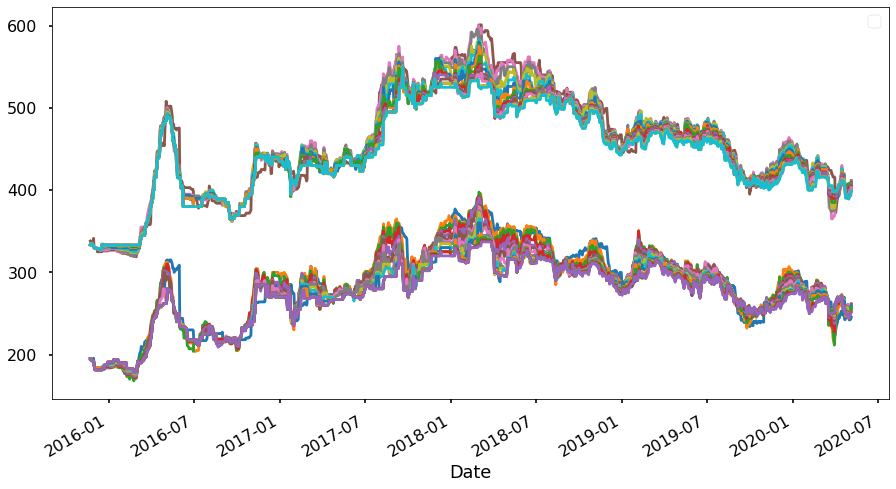

In [67]:
fig, ax = subplots()
price_df.plot(figsize=(15,8), ax=ax)
ax.legend([]);

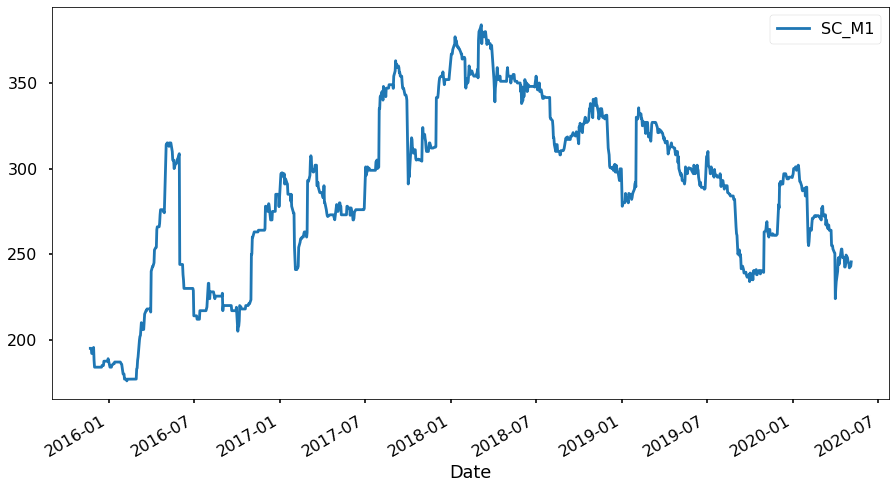

In [68]:
price_df[['SC_M1']].plot(figsize=(15,8))

# Model

In [0]:
to_predict = 'SC_M1'
data = all_df.reset_index().copy()
#data = data[['Date', to_predict]]

In [0]:
def add_caps(d1, d2=None, c='y'):
  if d2 is None:
    d2 = d1
  d2['cap'] = d1[c].max()
  d2['floor'] = d1[c].min()
  return d2

In [0]:
def generate_model(dff):
  dff = dff.copy()
  fecha = '2015-03-11'

  others = [c for c in dff.columns if c not in ['Date', to_predict]]
  dff.rename({'Date': 'ds', to_predict: 'y'}, axis=1, inplace=True)
  #dff = dff[['ds', 'y']]

  dff = dff.loc[dff.ds > fecha]
  dff = add_caps(dff)
  modelo_futuro = Prophet(growth='linear', seasonality_mode='additive', yearly_seasonality=True, daily_seasonality=True, weekly_seasonality=True)
  for o in others:
    modelo_futuro.add_regressor(o)
  print('Added', len(others), 'regressors')
  return modelo_futuro, dff

In [92]:
model, df_pred = generate_model(data)
df_pred.head()

Added 33 regressors


,ds,y,SC_M2,SC_M3,SC_M4,SC_M5,SC_M6,SC_M7,SC_M8,SC_M9,SC_M10,SC_M11,SC_M12,SC_M13,SC_M14,SC_M15,SR_M1,SR_M2,SR_M3,SR_M4,SR_M5,SR_M6,SR_M7,SR_M8,SR_M9,SR_M10,SR_M11,SR_M12,SR_M13,SR_M14,SR_M15,TV_SC,TV_SR,EOI_SC,EOI_SR,cap,floor
0,2017-01-04,297.0,299.0,288.0,280.0,275.0,273.5,271.5,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,442.0,445.0,441.0,439.0,438.0,438.0,438.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,172.0,144.0,2186.0,329.0,384.0,224.0
1,2017-01-05,297.5,299.0,287.0,282.0,272.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,435.5,447.0,444.5,442.0,438.0,438.0,438.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,954.0,174.0,2486.0,374.0,384.0,224.0
2,2017-01-06,297.5,297.0,286.0,283.0,272.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,435.0,443.5,439.0,435.5,433.0,430.0,433.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,1038.0,123.0,2486.0,397.0,384.0,224.0
3,2017-01-09,295.0,297.0,290.0,288.0,280.0,270.0,270.0,269.5,270.0,270.0,270.0,270.0,270.0,270.0,270.0,435.0,439.5,437.0,434.5,433.0,430.0,433.0,429.0,429.0,429.0,429.0,429.0,429.0,429.0,429.0,708.0,57.0,2429.0,412.0,384.0,224.0
4,2017-01-10,297.0,300.0,295.0,289.0,287.5,280.0,275.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,435.0,444.5,445.0,441.0,433.0,436.0,433.0,430.0,430.0,430.0,430.0,430.0,430.0,430.0,430.0,2012.0,121.0,2776.0,397.0,384.0,224.0


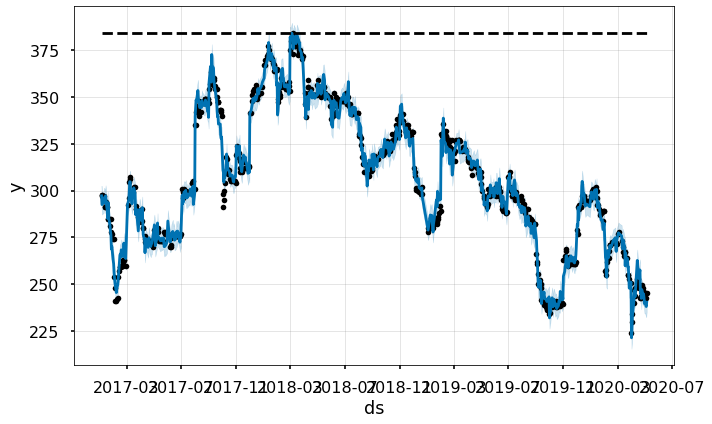

In [93]:
model.fit(df_pred)
forecast = model.predict(df_pred)
fig = model.plot(forecast)

In [94]:
forecast['fact'] = df_pred['y'].reset_index(drop = True)
print('Accuracy: {:.2f}%'.format(r2_score(forecast.fact, forecast.yhat)*100))

Accuracy: 98.58%


# Predict Future [EN PROCESO]

In [0]:
# 3 more months from end of data
future = model.make_future_dataframe(periods=90, freq='d', include_history=False)
future = df_pred.append(future)
future = add_caps(df_pred, future)

In [164]:
future.tail()

,y,SC_M2,SC_M3,SC_M4,SC_M5,SC_M6,SC_M7,SC_M8,SC_M9,SC_M10,SC_M11,SC_M12,SC_M13,SC_M14,SC_M15,SR_M1,SR_M2,SR_M3,SR_M4,SR_M5,SR_M6,SR_M7,SR_M8,SR_M9,SR_M10,SR_M11,SR_M12,SR_M13,SR_M14,SR_M15,TV_SC,TV_SR,EOI_SC,EOI_SR,cap,floor
ds,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,384.0,224.0
2020-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,384.0,224.0
2020-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,384.0,224.0
2020-08-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,384.0,224.0
2020-08-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,384.0,224.0


In [161]:
future.set_index(['ds'], inplace=True)
future.resample('M').count().head()

,y,SC_M2,SC_M3,SC_M4,SC_M5,SC_M6,SC_M7,SC_M8,SC_M9,SC_M10,SC_M11,SC_M12,SC_M13,SC_M14,SC_M15,SR_M1,SR_M2,SR_M3,SR_M4,SR_M5,SR_M6,SR_M7,SR_M8,SR_M9,SR_M10,SR_M11,SR_M12,SR_M13,SR_M14,SR_M15,TV_SC,TV_SR,EOI_SC,EOI_SR,cap,floor
ds,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-31,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
2017-02-28,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
2017-03-31,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
2017-04-30,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
2017-05-31,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16


In [173]:
future.index.to_period('M').to_timestamp('M')

DatetimeIndex(['2017-01-31', '2017-01-31', '2017-01-31', '2017-01-31',
               '2017-01-31', '2017-01-31', '2017-01-31', '2017-01-31',
               '2017-01-31', '2017-01-31',
               ...
               '2020-07-31', '2020-07-31', '2020-07-31', '2020-07-31',
               '2020-07-31', '2020-07-31', '2020-07-31', '2020-08-31',
               '2020-08-31', '2020-08-31'],
              dtype='datetime64[ns]', name='ds', length=851, freq=None)

In [180]:
future.groupby([future.index.month]).first()

,y,SC_M2,SC_M3,SC_M4,SC_M5,SC_M6,SC_M7,SC_M8,SC_M9,SC_M10,SC_M11,SC_M12,SC_M13,SC_M14,SC_M15,SR_M1,SR_M2,SR_M3,SR_M4,SR_M5,SR_M6,SR_M7,SR_M8,SR_M9,SR_M10,SR_M11,SR_M12,SR_M13,SR_M14,SR_M15,TV_SC,TV_SR,EOI_SC,EOI_SR,cap,floor
ds,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,297.0,299.0,288.0,280.0,275.0,273.5,271.5,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,442.0,445.0,441.0,439.0,438.0,438.0,438.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,172.0,144.0,2186.0,329.0,384.0,224.0
2,254.0,254.0,253.0,258.0,255.0,258.0,251.5,251.5,245.0,245.0,245.0,245.0,245.0,245.0,245.0,407.5,410.0,410.0,410.0,410.0,411.0,406.0,406.0,406.0,406.0,406.0,410.0,410.0,410.0,410.0,1059.0,231.0,3633.0,723.0,384.0,224.0
3,292.5,288.0,288.0,288.0,282.0,279.0,276.0,275.0,274.0,272.0,270.0,268.0,268.0,268.0,268.0,450.0,453.5,450.0,447.0,442.0,438.0,438.0,438.0,437.0,437.0,435.0,435.0,435.0,435.0,435.0,1994.0,189.0,4596.0,1014.0,384.0,224.0
4,283.0,283.0,280.0,278.5,275.0,275.0,273.0,270.5,265.0,265.0,260.0,260.0,260.0,260.0,260.0,436.0,436.0,436.0,436.0,436.0,432.5,428.0,429.0,429.0,426.0,420.0,420.0,420.0,420.0,420.0,373.0,278.0,4391.0,669.0,384.0,224.0
5,279.0,280.0,281.0,279.0,277.0,276.0,275.0,271.5,267.0,267.0,267.0,267.0,267.0,267.0,267.0,435.0,437.0,437.0,437.0,434.0,433.0,430.0,430.0,430.0,430.0,430.0,430.0,430.0,430.0,430.0,278.0,173.0,4684.0,1421.0,384.0,224.0
6,277.0,277.0,277.0,277.0,277.0,277.0,278.0,274.0,274.0,274.0,274.0,274.0,274.0,274.0,274.0,448.0,448.0,445.0,445.0,443.0,443.0,438.0,440.0,440.0,440.0,440.0,440.0,440.0,440.0,440.0,6.0,51.0,3836.0,844.0,384.0,224.0
7,301.0,301.5,300.0,295.0,292.5,298.0,288.5,288.5,283.5,283.5,283.5,283.5,283.5,283.5,283.5,452.0,452.0,452.0,450.0,448.0,445.0,445.5,442.5,440.0,440.0,440.0,440.0,440.0,440.0,440.0,1085.0,282.0,4474.0,813.0,384.0,224.0
8,335.0,331.0,325.0,320.0,311.0,308.0,304.0,298.0,298.0,295.0,280.0,280.0,280.0,280.0,280.0,511.0,498.0,495.0,483.0,480.0,480.0,481.0,476.5,467.0,465.0,460.0,460.0,460.0,455.0,455.0,3208.0,180.0,5053.0,773.0,384.0,224.0
9,354.0,349.0,345.0,329.0,326.0,312.0,308.0,303.0,300.0,295.0,295.0,295.0,295.0,295.0,295.0,546.0,542.0,537.0,526.0,522.0,508.0,510.0,507.5,495.0,495.0,495.0,495.0,495.0,495.0,495.0,1163.0,222.0,4779.0,878.0,384.0,224.0


In [174]:
# Iterate through dates in batches of 30 days (1 month aprox) --> maybe 30.25??
# Substract amount of months since start
# assign corresponding data to batch rows

def fill_future(d, end):
  d = d.copy()
  d2 = d.loc[d.index > end]
  for m in d.index.to_period('M').to_timestamp('M'):
    print(m)
  #for m in d2.resample('M').count():
  #  print(m)
  d.loc[d.index > end] = d2
  return d
    
fill_future(future, df_pred.ds.values[-1])
1

2017-01-31 00:00:00
2017-01-31 00:00:00
2017-01-31 00:00:00
2017-01-31 00:00:00
2017-01-31 00:00:00
2017-01-31 00:00:00
2017-01-31 00:00:00
2017-01-31 00:00:00
2017-01-31 00:00:00
2017-01-31 00:00:00
2017-01-31 00:00:00
2017-01-31 00:00:00
2017-01-31 00:00:00
2017-01-31 00:00:00
2017-01-31 00:00:00
2017-01-31 00:00:00
2017-01-31 00:00:00
2017-01-31 00:00:00
2017-01-31 00:00:00
2017-01-31 00:00:00
2017-02-28 00:00:00
2017-02-28 00:00:00
2017-02-28 00:00:00
2017-02-28 00:00:00
2017-02-28 00:00:00
2017-02-28 00:00:00
2017-02-28 00:00:00
2017-02-28 00:00:00
2017-02-28 00:00:00
2017-02-28 00:00:00
2017-02-28 00:00:00
2017-02-28 00:00:00
2017-02-28 00:00:00
2017-02-28 00:00:00
2017-02-28 00:00:00
2017-02-28 00:00:00
2017-02-28 00:00:00
2017-02-28 00:00:00
2017-03-31 00:00:00
2017-03-31 00:00:00
2017-03-31 00:00:00
2017-03-31 00:00:00
2017-03-31 00:00:00
2017-03-31 00:00:00
2017-03-31 00:00:00
2017-03-31 00:00:00
2017-03-31 00:00:00
2017-03-31 00:00:00
2017-03-31 00:00:00
2017-03-31 00:00:00


1

In [0]:
future_forecast = model.predict(future)
fig = model.plot(future_forecast)

ValueError: ignored

In [0]:
future_forecast['fact'] = future['y'].reset_index(drop = True)
print('Accuracy: {:.2f}%'.format(r2_score(future_forecast.fact, future_forecast.yhat)*100))

Accuracy: 99.05%
